In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


# **Library Imports**

In [1]:
import re #libray for regular expression
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Loading Data

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Github Projects/3. Spam Detection in Emails/completeSpamAssassin.csv')

In [10]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


# **Data Cleaning and Preprocessing**

In [11]:
df = df.drop(columns = 'Unnamed: 0', axis='columns')
df = df[df['Body']!= 'empty']

In [12]:
final_df =  df

In [13]:
final_df['Body'].duplicated().sum()

221

In [14]:
final_df = final_df.drop_duplicates()

In [15]:
final_df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [16]:
data = final_df.where((pd.notnull(final_df)), '')

In [17]:
data.isna().sum().sum()

0

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5292 entries, 0 to 6043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    5292 non-null   object
 1   Label   5292 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 124.0+ KB


In [19]:
data.shape

(5292, 2)

In [20]:
data.reset_index(drop=True, inplace=True)

# **Text Vecorization**

In [21]:
ps = PorterStemmer()
corpus = []
for index, row in data.iterrows():
  review = re.sub('[^a-zA-Z]', ' ', row['Body'])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [22]:
tokenized_corpus = [sentence.split() for sentence in corpus]

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=500, window=5, min_count=1, workers=4)

# Function to convert sentence to vector
def sentence_vector(sentence, model, vector_size=500):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Transform the corpus into vectors
X = np.array([sentence_vector(sentence, word2vec_model) for sentence in corpus])

y = data['Label']

In [23]:
len(X), len(y)

(5292, 5292)

# **Train Test Split**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state= 3)


# **Oversampling**

In [25]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# **Model Training and Performance Metrics**

In [26]:
classifiers = {
    "XGBoost": (XGBClassifier(
        eval_metric='logloss',
        tree_method='hist'
    ), {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}),

    "LightGBM": (LGBMClassifier(
        boosting_type='gbdt',
        n_jobs=-1,  # Use all CPU cores
        verbosity=-1  # Suppress logs
    ), {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}),

    "AdaBoost": (AdaBoostClassifier(), {
        'n_estimators': [50, 100],  # Reduce the search space
        'learning_rate': [0.05, 0.1]
    }),

    "CatBoost": (CatBoostClassifier(
        verbose=0,  # Suppress logs
        task_type="CPU"  # Use CPU (change to "GPU" if needed)
    ), {'iterations': [50, 100], 'learning_rate': [0.05, 0.1]})
}

In [27]:
best_estimators = {}
performance_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
}

## Model Training and Perfomance (Count Vectorizer - Bag of Words)



Best Parameters for XGBoost:
 {'learning_rate': 0.1, 'n_estimators': 100}
Confusion Matrix for XGBoost:
 [[744  24]
 [ 19 272]]
Accuracy Score for XGBoost: 0.96
Precision for XGBoost: 0.96
Recall for XGBoost: 0.96
F1 Score for XGBoost: 0.96


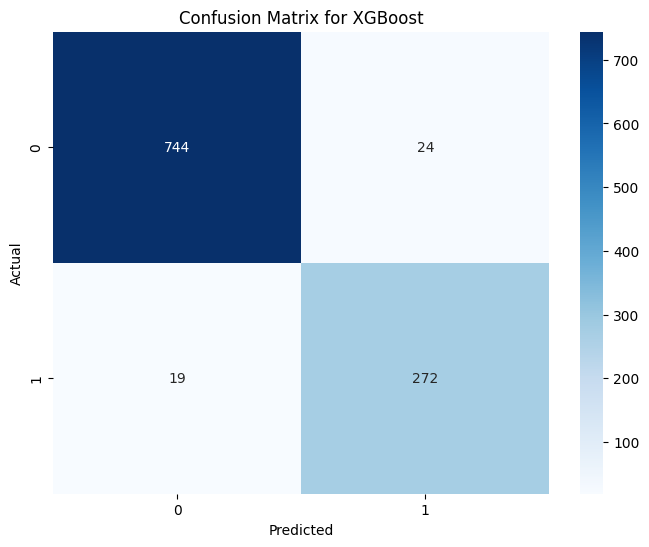

Best Parameters for LightGBM:
 {'learning_rate': 0.1, 'n_estimators': 100}
Confusion Matrix for LightGBM:
 [[745  23]
 [ 16 275]]
Accuracy Score for LightGBM: 0.96
Precision for LightGBM: 0.96
Recall for LightGBM: 0.96
F1 Score for LightGBM: 0.96


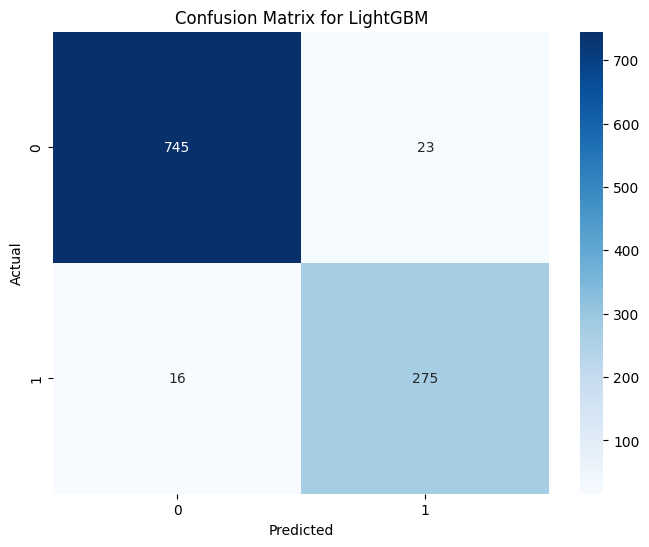

Best Parameters for AdaBoost:
 {'learning_rate': 0.1, 'n_estimators': 100}
Confusion Matrix for AdaBoost:
 [[720  48]
 [ 51 240]]
Accuracy Score for AdaBoost: 0.91
Precision for AdaBoost: 0.91
Recall for AdaBoost: 0.91
F1 Score for AdaBoost: 0.91


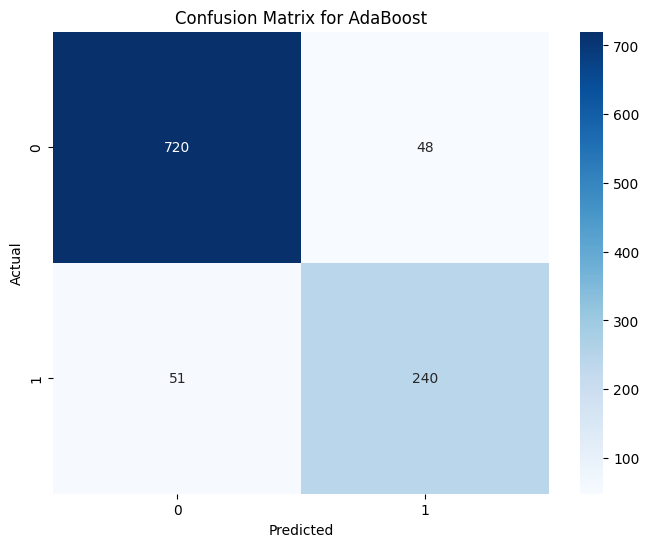

Best Parameters for CatBoost:
 {'iterations': 100, 'learning_rate': 0.1}
Confusion Matrix for CatBoost:
 [[744  24]
 [ 18 273]]
Accuracy Score for CatBoost: 0.96
Precision for CatBoost: 0.96
Recall for CatBoost: 0.96
F1 Score for CatBoost: 0.96


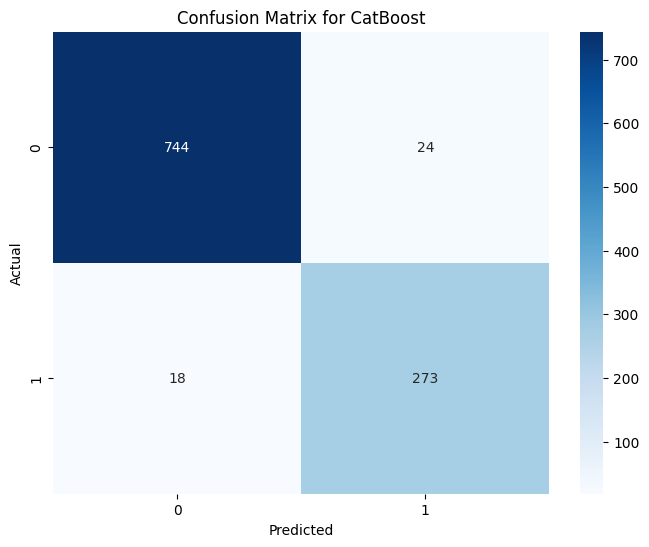

In [28]:
for name, (clf, param_grid) in classifiers.items():
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_res, y_train_res)
    best_clf = grid_search.best_estimator_
    best_estimators[name] = best_clf
    # Make predictions
    y_pred = best_clf.predict(X_test)
    y_prob = best_clf.predict_proba(X_test)[:, 1] if hasattr(best_clf, 'predict_proba') else None
    # Compute confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

    # Print best parameters and performance metrics
    print(f"Best Parameters for {name}:\n", grid_search.best_params_)
    print(f"Confusion Matrix for {name}:\n", confusion)
    print(f"Accuracy Score for {name}: {accuracy:.2f}")
    print(f"Precision for {name}: {precision:.2f}")
    print(f"Recall for {name}: {recall:.2f}")
    print(f"F1 Score for {name}: {f1:.2f}")

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()